# System Setup

In [1]:
!pip install opendatasets --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install jovian --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 KB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for uuid: filename=uuid-1.30-py3-none-any.whl size=6502 sha256=628734480e0863f7df3533add448287acb14fc7a0e99ab34ec90a9d28e4e62c6
  Stored in directory: /root/.cache/pip/wheels/05/d7/b4/4795d29c6decfffbf64c63e58b6c8b8bbfd4751488617dcd7a
Successfully built uuid


In [3]:
import jovian

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision import transforms, utils, datasets, models
from torch.autograd import Variable
from keras.optimizers import Adam
import glob
import os
import numpy as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pathlib
import opendatasets as od


# Preparing Data


Rice Image Dataset contains image data of rice images under 5 categories:

'Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag', separated in each folder.

There are around 7.5k images in total.
Our goal is to train the model to identify which type the rice is.



In [5]:
dataset_url = 'https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset'
od.download(dataset_url)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key: ··········


100%|██████████| 219M/219M [00:10<00:00, 21.2MB/s]


In [6]:
path = pathlib.Path("../content/rice-image-dataset/Rice_Image_Dataset")


In [7]:
arborio = list(path.glob('Arborio/*'))
basmati = list(path.glob('Basmati/*'))
ipsala = list(path.glob('Ipsala/*'))
jasmine = list(path.glob('Jasmine/*'))
karacadag = list(path.glob('Karacadag/*'))

total_list=arborio + basmati + ipsala + jasmine + karacadag



In [8]:
data_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor()
    ]
)

model_dataset = datasets.ImageFolder(path, transform=data_transform) 

image, label = model_dataset[0]
print(f"Image Size: {image.shape}")
print(f"Label: {label}")
print(image)


Image Size: torch.Size([3, 250, 250])
Label: 0
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


Classes: 5 - ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag'] 
Examples: 75000
Counts: {'Arborio': 15000, 'Basmati': 15000, 'Ipsala': 15000, 'Jasmine': 15000, 'Karacadag': 15000}


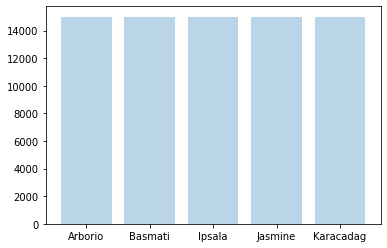

In [9]:
classes = model_dataset.classes

def describe_dataset(data):
    classes_count = { c:0 for c in classes}
    for _,label in data:
        classes_count[classes[label]]+=1

    print(f'Classes: {len(classes)} - {classes} ')
    print(f'Examples: {len(data)}')
    print(f'Counts: {classes_count}')
    plt.bar(classes_count.keys(),classes_count.values(), alpha=0.3 )

    return classes_count

_ = describe_dataset(model_dataset)

As you can observe in the bar plot, all the classes have the same number of samples.


Label:  Arborio (0)


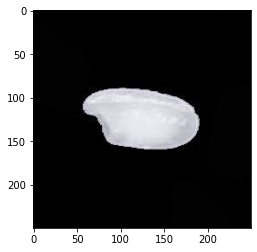

In [10]:
def show_example(img, label):
    print('Label: ', classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
show_example(*model_dataset[0])

All images must have the same shape to train the model correctly. We need remove all those samples that don't have the right shape.

In [11]:
data_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((100,100)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]
        ),
    ]
)
BATCH_SIZE=256

model_dataset = datasets.ImageFolder(path, transform=data_transform) 
train_count = int(0.7 * len(total_list)) 
valid_count = int(0.2 * len(total_list))
test_count = len(total_list) - train_count - valid_count
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(model_dataset, (train_count, valid_count, test_count))
train_dataset_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)  
valid_dataset_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True) 
test_dataset_loader  = torch.utils.data.DataLoader(test_dataset , batch_size=BATCH_SIZE, shuffle=False)
dataloaders = {'train': train_dataset_loader, 'val': valid_dataset_loader, 'test': test_dataset_loader}

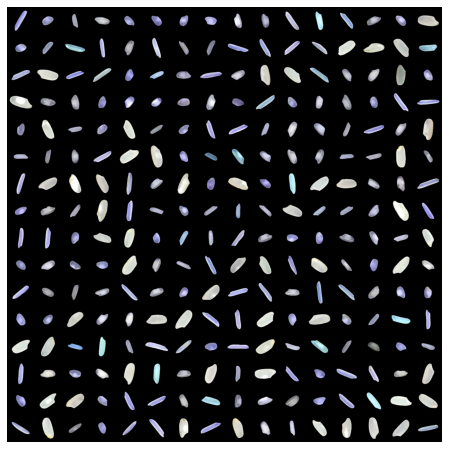

In [12]:
for item in train_dataset_loader:
    plt.figure(figsize=(16, 8))
    image, _ = item
    plt.imshow(make_grid(image, nrow=16).permute(1, 2, 0))
    plt.axis("off")
    plt.show()
    break


# Define model



In [13]:
class CustomizedConvNet(nn.Module):
    def __init__(self):
        super().__init__() #Inheritance
        self.network =  nn.Sequential(
          nn.Conv2d(in_channels=3,out_channels=12,padding=1,kernel_size=3),
          nn.BatchNorm2d(num_features=12),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),
          
          nn.Conv2d(in_channels=12,out_channels=20,padding=1,kernel_size=3),
          nn.BatchNorm2d(num_features=20),
          nn.ReLU(),
          
          nn.Conv2d(in_channels=20,out_channels=32,padding=1,kernel_size=3),
          nn.BatchNorm2d(num_features=32),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),
          
          nn.Flatten(), 
          nn.Linear(32*25*25, 512),
          nn.ReLU(),
          nn.Linear(512, 5)
        )
    
    def forward(self, Input):
      return self.network(Input)
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = self.loss_fn(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))



In [14]:
CustomizedConvNet()


CustomizedConvNet(
  (network): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=20000, out_features=512, bias=True)
    (13): ReLU()
    (14): Linear(in_features=512, out_features=5, bias=True)
  )
)

In [15]:
model = CustomizedConvNet()
device='cuda'
model = model.to(device)
model


CustomizedConvNet(
  (network): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=20000, out_features=512, bias=True)
    (13): ReLU()
    (14): Linear(in_features=512, out_features=5, bias=True)
  )
)

In [16]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


In [17]:
def accuracy(pred, label):
    _, out = torch.max(pred, dim=1)
    return torch.tensor(torch.sum(out == label).item()/len(pred))

def validation_step(valid_dl, model, loss_fn):
    for image, label in valid_dl:
        out = model(image)
        loss = loss_fn(out, label)
        acc = accuracy(out, label)
        return {"val_loss": loss, "val_acc": acc}
def fit_to_model(train_dl, valid_dl, epochs, optimizer, loss_fn, model):
    history = []
    for epoch in range(epochs):
        for image, label in train_dl:
            out = model(image)
            loss = loss_fn(out, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            
        val = validation_step(valid_dl, model, loss_fn)
        print(f"Epoch [{epoch}/{epochs}] => loss: {loss}, val_loss: {val['val_loss']}, val_acc: {val['val_acc']}")
        history.append({"loss": loss, 
                        "val_loss": val['val_loss'], 
                        "val_acc": val['val_acc']
                       })
    return history
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)

            

In [18]:
train_dataset_loader= DeviceDataLoader(train_dataset_loader, device)
valid_dataset_loader = DeviceDataLoader(valid_dataset_loader, device)


# Train model

In [19]:
Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 5
history = fit_to_model(train_dataset_loader, valid_dataset_loader, epochs, optimizer, Loss, model)


Epoch [0/5] => loss: 0.08294568955898285, val_loss: 0.037703972309827805, val_acc: 0.984375
Epoch [1/5] => loss: 0.11372093856334686, val_loss: 0.012059206143021584, val_acc: 1.0
Epoch [2/5] => loss: 0.0792483314871788, val_loss: 0.02513505332171917, val_acc: 0.98828125
Epoch [3/5] => loss: 0.002711321460083127, val_loss: 0.010433937422931194, val_acc: 0.99609375
Epoch [4/5] => loss: 0.0037686717696487904, val_loss: 0.021445104852318764, val_acc: 0.99609375


# Testing with individual images 

Predict with one image of rice with the type of Arborio

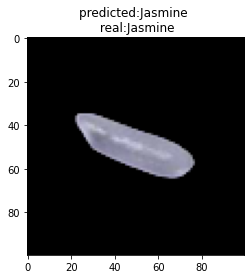

In [20]:
model = model.cpu()
with torch.no_grad():
    
    for img,label in test_dataset_loader:
        imgs = img[10]
        labels = label[10]

        output_model = imgs.unsqueeze(0)
        output_model = model(output_model)
        index = output_model.argmax()
        imgs = torch.permute(imgs,(1,2,0))
        plt.imshow(imgs)
        plt.title(f"predicted:{ model_dataset.classes[index]} \n real:{ model_dataset.classes[labels]}")
        break


# Evaluate Model


In [21]:
def evaluate(model, test_dl):
  i = 0
  correct = 0
  for img,label in test_dl:
      imgs = img[10]
      labels = label[10]
      output_model = imgs.unsqueeze(0)
      output_model = model(output_model)
      index = output_model.argmax()
      imgs = torch.permute(imgs,(1,2,0))
      if model_dataset.classes[index] == model_dataset.classes[labels]:
        correct=correct+1
      i=i+1
  return correct/i


In [22]:
test_result = evaluate(model, test_dataset_loader)
test_result


0.9333333333333333

# Saving and committing the results

In [24]:
jovian.log_hyperparams(arch='cnn', 
                       epochs=epochs, 
                       lr=0.001)

[jovian] Please enter your API key ( from https://jovian.com/ ):
API KEY: ··········
[jovian] Hyperparams logged.


In [25]:
torch.save(model.state_dict(), 'cuscnn-cnn.pth')


# Summary

Summary
In this project we trained Deep Learning models to classify pictures of rice from 5 classes:

'Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag'

The model one was defined using convoutional layers, get accuracy score of 93.33%.


Thanks to Jovian.ai, Aakash, and the Jovian Community for supporting me thoughout the amazing course.